Outline:

	1.	Problem setup + data (set_strings)
	2.	Q1 LCS function (all LCSs) + tests
	3.	Q2 LCS-length matrix + interpretation
	4.	Q3 Local vs Global strategy (design)
	5.	Q4 Implement + draw trees + compare
	6.	Q5 Complexity (theory + experimental plots)
	7.	Q6 Mutation probability estimation (idea + code + sanity check)


Q1 LCS function (all LCSs) + tests

Let set_strings refer to the set of strings created with the gene-sequencing generation program.

1. Write Python code that, given any two arbitrary strings, outputs all of the Longest Common
Subsequences (LCSs) for those two strings and their corresponding lengths. Include several
test cases that demonstrate that your code is correct.

In [126]:
def lcs_tables(x, y):
    """
    Construct the DP tables for the LCS problem, following the algorithm LCS-LENGTH from Cormen et al.

    Function compares two strings x and y and computes:
    1) A table of LCS lengths for all prefixes of the strings.
    2) A table of directional choices that records how each LCS length was obtained.

    Parameters
    ----------
    x : str
        The first input string.
    y : str
        The second input string.

    Returns
    -------
    c : list of lists of int
        The LCS length table, where c[i][j] is the length of a longest common
        subsequence of the prefixes x[:i] and y[:j].
    b : list of lists of str
        The direction table used for reconstruction. Each entry is one of:
          - "NW" : diagonal move (characters matched),
          - "N"  : move up (skip a character from x),
          - "W"  : move left (skip a character from y).
    """
    # lenghts of strings
    m = len(x)
    n = len(y)

    # create c and b tables 
    c = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    b = [["" for _ in range(n + 1)] for _ in range(m + 1)]

    # fill in tables
    for i in range(1, m + 1):
        for j in range(1, n + 1):

            if x[i - 1] == y[j - 1]:
                c[i][j] = c[i - 1][j - 1] + 1
                b[i][j] = "NW" # diagonal 

            else:
                if c[i - 1][j] >= c[i][j - 1]:
                    c[i][j] = c[i - 1][j]
                    b[i][j] = "N" # up
                else:
                    c[i][j] = c[i][j - 1]
                    b[i][j] = "W" #left

    return c, b

def reconstruct_lcs(x, y, c, i, j, memoization):
    """
    Recursively reconstruct all LCSs of x[:i] and y[:j] using the CLRS LCS length table.

    This function follows the same logic used in Cormen et al. to reconstruct an LCS, but 
    extends it to return all the possible LCSs.

    Memoization ensures that each subproblem (i, j) is solved only once, avoiding redundant 
    recursion when multiple optimal paths exist
    
    Parameters
    ----------
    x : str
        input of first string
    y : str
        input of second string
    c : list of lists of int 
        LCS length table produced by teh lcs_tables)
    i : int 
        the current index into x
    j : int
        the current index into y
    memoization : dict 
        Memoization dictionary mapping (i, j) to a set of LCS strings

    Returns
    -------
    set of str: all longest common subsequences of x[:i] and y[:j].
    """
    # if we have already solved this subproblem, we return the stored result
    if (i, j) in memoization:
        return memoization[(i, j)]

    # base case: one of the prefixes is empty
    if i == 0 or j == 0:
        memoization[(i, j)] = {""}
        return memoization[(i, j)]

    # case 1: last characters match
    if x[i - 1] == y[j - 1]:

        previous_lcs = reconstruct_lcs(x,y, c, i - 1, j - 1, memoization)

        result = set()
        for seq in previous_lcs:
            result.add(seq + x[i - 1])

        memoization[(i, j)] = result
        return result

    # case 2: last characters do not match
    results = set()

    # move up if it preserves the optimal LCS length
    if c[i - 1][j] >= c[i][j - 1]:
        upper_results = reconstruct_lcs(x, y, c, i - 1, j, memoization)
        results.update(upper_results)

    # move left if it preserves the optimal LCS length
    if c[i][j - 1] >= c[i - 1][j]:
        left_results = reconstruct_lcs(x, y, c, i, j - 1, memoization)
        results.update(left_results)

    memoization[(i, j)] = results
    return results


def find_lcs(x, y):
    """
    This function finds all LCSs between two strings.
    It follows the dynamic programming approach described in Cormen et al. by first
    computing the LCS length table and then backtracking through this table to recover
    the subsequences. 
    Cormen et al. describes how to recover a single LCS, but this function extends the 
    method to return all possible LCSs of maximum length.

    Parameters
    ----------
    x : str
        First input string
    y : str
        Second input string

    Returns
    -------
    (list[str] | None, int)
        A tuple containing:
        - a sorted list of all longest common subsequences,
        - the length of the LCS.

        If there is no common subsequence, returns (None, 0).
    """
    # handle edge cases where one string is empty
    if not x or not y:
        return None, 0

    # building the LCS tables using the CLRS algorithm
    c, _ = lcs_tables(x, y) #we only need the length table c, the direction table b is not required here

    # the LCS length is stored in the bottom-right cell of the table
    lcs_length = c[len(x)][len(y)]

    if lcs_length == 0:
        return None, 0

    # reconstruct all LCSs using the memoization
    memoization = {}
    lcs_set = reconstruct_lcs(x, y, c, len(x), len(y), memoization)

    # remove empty string if present
    lcs_set.discard("")

    return sorted(lcs_set), lcs_length

Test Cases:

In [127]:
# Test 1: CLRS example 
x1 = "ABCBDAB"
y1 = "BDCABA"
assert find_lcs(x1, y1) == (['BCAB', 'BCBA', 'BDAB'], 4)

# Test 2: one empty string
# tests the base case 
x2 = "abc"
y2 = ""
assert find_lcs(x2, y2) == (None, 0)

# Test 3: one single character match
# edge case with small input --> see if DP table is reconctructed correctly
x3 = "abc"
y3 = "a"
assert find_lcs(x3, y3) == (['a'], 1)

# Test 4: case sensitivity check
# edge case to check if character nature matters 
x4 = "ABC"
y4 = "abc"
assert find_lcs(x4, y4) == (None, 0)

# Test 5: identical strings
# best case scenario for LCS --> the full string is returned; no duplicates introduced 
x5 = "genetics"
y5 = "genetics"
assert find_lcs(x5, y5) == (['genetics'], len("genetics"))

# Test 6: no common characters
# edge case where no charecters match 
x6 = "xyz"
y6 = "abc"
assert find_lcs(x6, y6) == (None, 0)

# Test 7: Mixed-case characters (partial match)
# checking if the algorithm handels symbol matching correctly 
x7 = "AbC"
y7 = "abc"
assert find_lcs(x7, y7) == (['b'], 1)

print("All LCS tests passed!")

All LCS tests passed!


Q2 LCS-length matrix + interpretation

2. How many unique LCSs lengths are there in set_strings? Generate the matrix of the lengths
of the LCS for every (non-trivial) pair in set_strings. Make sure that your matrix obeys the
following properties:

    a. The matrix should be cast as a two-dimensional numpy array and stored in a variable named len_lcs_matrix.

    b. Your 2D array len_lcs_matrix should have dimension (7,7), and len_lcs_matrix[i,j] should give the length of the LCS for the ith and jth strings. For example, len_lcs_matrix[0,3] gives the length of the LCS for string a and string d.

    c. Manually examine the matrix you obtained above.

            i. Explain how you would infer (directly from this matrix or on other matrices obtained from this one) which strings are more strongly related to each other.
            ii. Could you infer the resulting genealogy binary tree using this information alone? Why or why not?

In [128]:
set_strings = [
    ('a',
     "TGGTGGGAACATTGATCTGCTTTTACGGTGACAGTCTAGTTTTTGGTACCCCTGCGGAACGATTGGGCCATCTACAGTGCCCGCGCCACAGTTTAAAGTAGTGACGTGGATCTGATATTAACAGAGGACGTTGTTGGACGGAAACTTATCACCCAGCTAACAATCATATGATGAACCCGACGTTACGGTGATGAGTGACCCATTACTGTCAACACGCATGAAGATCGCGCCCGTAGGCCACGCTCTTAGTAATGACCGTTGCTCCACATATGTTTCCGACATCTGTGTCGTCTTTGGAAGAACCTATATCGTAGCAGGAGGGATGTGTACTCGG"),

    ('b',
     "TGGTACGAAGGCATCTCTTTTCCCGTGGCGTGATGGTGTTATGGGTATCCACCCGAACGGTGGCGTCTACAACTCTCCCAAGATATACGAGCGAGTTAGAGCTTAATTAAACAGAGGGCGTCGTTGACGTCATTAGGGCACCAGCATGAATCAACCGCATGAACCGTTATCGTGGGTTTCAGGACTCTATGTAAAAGGATGAAGATTTTCGCAACAGCTACTAAATAATGGAGTGTGTACAATAATGCAACCCTACACCGTGCAATCTTGTCACTGCTAGTAGAGCCTGGGGATTGGTTCCTCGG"),

    ('c',
     "TGGTCGAAGGCATCTATTTTGCCGTGCGCGTGCTGGTGTAATTGGCAATCCACCCGAACGGTCTCGTCTACCACTCTCCCAAGAGTATACGAGCGCAGTCAGACCTCTACATAAACATAGGGCGTCCTTTACGTCATTAGGCCACCAGCGATGAATCAACCTCATCGAACCCTTATGGTGGGTTTACGCAGCTCTCTACTAAAAGCACTCGTGAGGTTTTCGTCAACAGCTACTAAATAATTCAAGGTGTGCAAATTGCATACCCAACACCGTGCAATCTTGTCCTGATAGTAGAGCATGGGGGAGTCTAGGGACCTCGG"),

    ('d',
     "GGGTGCGACCAAGATCTATTTCTCCGTGACGGATAAGGTCTCTATTTGTCCTTCCTGGGAATCGATTGGAAACCTACATTCAGCGAGCAGTATAAGTAGGGACGTAGATCATTATATTATATCTAGAGGGCGTGGTTTGGGACGCAAGTTTCCAGCGGAACTAGGAATCGTCCGATGAACTCCTACGATGAGAGAGTCCGTGAACTATAGGGGCAGAAGGATTGATATGCGCCGAGGACCACGATCATTAGTAATGAGCGTTGCGTCACATATGTATCCCGACCATTCGGTCGTCTTGGAACTATCTTGATCGTACCCACGGAGGATGTTTCTCGG"),

    ('e',
     "GGGTGCGACAAGATCTCTTTTCCGTGACGTATAGTTTTATGGTACTCCCCGGAACGATTGGCAACTACAATCCCGCGAACAGTATAAGTAGTGACGTAGATCTTATATTAACAGAGGGCGTTGTTGGACGCAAGTATCACCAACTAGAATCATCCGATGAACTCGACGTGAGGTGTCAGTGAACTATAGGGCAAAGGATGAATATGCGCCGAGGCCACGCTCTAGTAATGAGCGTTGCTCACATATGTATCCGACATCGGTCGTCTTGGAACTACCTAGATCGTAGCAGGAGGATGTTACTCGG"),

    ('f',
     "TGGTGCGAAAGCATCTCTTTTCCGTGGCGTATAGTTTTATGGTATCCCCGGAACGCTGGCTACTACAATCTCCGAAGTATAGAGTGAGTAGATTTAATTAACAGAGGGCGTCGTTGACGCATTAGCACCAACTGAATCAACCGATAACTTAACGTGGGTTTCAGTGACTATAGGGCAAAGGATGAACATTTTCGAGCAGCTCTAATAATGAGCGTGACAATATGAATCCACACCGTCATCTTGAACTCCTAGATTGAGCAAGAGGTTGTTCCTCGG"),

    ('g',
     "TGGGACGTAGGCACCTCTTTTCCCGTGGCGTGATGGGTGTGACGGGTATCCACCCGTACGGGCACCTCTTAACAACGCTCTCACTAAGATCATACGAGCGAGTATAGAGCTTAATTACCAGAGGGACCTCGCTGCCGACATTAGAGGCAACCAGCATGAACTCAAGCCCCAATGTAACGTCATCGTGGGGATTGCAGGACTCTATATAAAAGGATGAAAGGAATTTTCCGCAACCAGTTACTAAAGTAAATGGAGTGTGTACAAATAATGTGAAGCCCTCACACCGTGCCTCTTTGTCACTGCGTAGTAAGGAGCACTAGGTGTATTGGTTCGCTCGG")
]

In [129]:
def lcs_length(x, y):
    """
    Computing the length of the LCS between two strings.

    This function follows the same dynamic programming recurrence as the
    LCS-LENGTH algorithm described in Cormen et al., but only computes
    the final LCS length (not the subsequence itself).

    In order to reduce memory usage, we store only two rows of the DP table at a time: the previous row and the current row. 
    This is possible because each DP c[i][j] depends only on c[i-1][j], c[i][j-1], and c[i-1][j-1].

    Parameters
    ----------
    x : str
    y : str

    Returns
    -------
    int
        Length of the longest common subsequence between x and y.
    """

    # making sure that y is the shorter string to minimize memory usage
    if len(y) > len(x):
        x, y = y, x

    m, n = len(x), len(y)

    # prev[j] represents c[i-1][j]
    # curr[j] represents c[i][j]
    prev = [0] * (n + 1)
    curr = [0] * (n + 1)

    # Build the DP table row by row (CLRS recurrence)
    for i in range(1, m + 1):
        xi = x[i - 1]
        curr[0] = 0  # base case: LCS with empty prefix is 0

        for j in range(1, n + 1):
            if xi == y[j - 1]:
                # If characters match, then extend the LCS
                curr[j] = prev[j - 1] + 1
            else:
                # If characters do not match, then take the best of skipping one character
                curr[j] = max(prev[j], curr[j - 1])

        # move current row to prev for next iteration
        prev, curr = curr, prev

    # Final LCS length is in the last cell of the last completed row
    return prev[n]

In [130]:
import numpy as np

"""
Constructing a pairwise LCS length matrix for all strings in set_strings.

Each entry len_lcs_matrix[i, j] stores the length of the LCS betweenthe i-th and j-th strings. 
This matrix summarizes pairwise similarity between all gene sequences.

"""

n = len(set_strings)

# initialize a 7x7 matrix of integers
len_lcs_matrix = np.zeros((n, n), dtype=int)

for i in range(n):
    seq_i = set_strings[i][1]

    len_lcs_matrix[i, i] = len(seq_i) # the LCS of a string with itself is the full length of the string

    
    for j in range(i + 1, n):
        seq_j = set_strings[j][1] #compute only the upper triangle and mirror (matrix is symmetric)

        # Compute LCS length using DP (CLRS)
        length = lcs_length(seq_i, seq_j)

        len_lcs_matrix[i, j] = length
        len_lcs_matrix[j, i] = length  # symmetry

len_lcs_matrix

array([[334, 226, 223, 255, 270, 226, 228],
       [226, 305, 266, 228, 235, 248, 279],
       [223, 266, 320, 223, 222, 228, 251],
       [255, 228, 223, 336, 278, 233, 231],
       [270, 235, 222, 278, 304, 250, 229],
       [226, 248, 228, 233, 250, 276, 235],
       [228, 279, 251, 231, 229, 235, 338]])

In [131]:
"""
Non-trivial pairs correspond to comparisons between different strings (i != j).
We are extracting only the upper-triangular entries (i < j) to avoid duplicates.
"""

upper_triangle_values = len_lcs_matrix[np.triu_indices(n, k=1)]

unique_lcs_lengths = np.unique(upper_triangle_values)

print("Unique LCS lengths (non-trivial pairs):", unique_lcs_lengths)
print("Number of unique LCS lengths:", len(unique_lcs_lengths))

Unique LCS lengths (non-trivial pairs): [222 223 226 228 229 231 233 235 248 250 251 255 266 270 278 279]
Number of unique LCS lengths: 16


In [132]:
"""
Printing the matrix in a readable format to manually examine it.
"""
labels = [label for label, _ in set_strings]

# Print column headers
print("     " + "  ".join(f"{lab:>4}" for lab in labels))

# Print each row with its corresponding label
for i in range(n):
    row_values = "  ".join(f"{len_lcs_matrix[i, j]:>4}" for j in range(n))
    print(f"{labels[i]:>4}  {row_values}")

        a     b     c     d     e     f     g
   a   334   226   223   255   270   226   228
   b   226   305   266   228   235   248   279
   c   223   266   320   223   222   228   251
   d   255   228   223   336   278   233   231
   e   270   235   222   278   304   250   229
   f   226   248   228   233   250   276   235
   g   228   279   251   231   229   235   338


Q3 Local vs Global strategy

3. You will now examine the precise relationships between strings (i.e., explicitly identify
grandparent, parent, and child strings). You will do so by proposing two strategies: one that is
local and another that is global. Note:

    a. A local strategy infers the location of a particular string in the tree based on a greedy property (of your choice) of the node itself.

        i. Specifically, we compare each node with its immediate neighbors. For instance, we compare the root with its children only, but not with its grandchildren. This comparison can be achieved using a greedy approach, a dynamic programming approach, or a combination of both.

    b. A global strategy infers the whole tree based on a metric obtained by considering all the relationships involved in that tree at once.
    
        i. This is very similar to the dynamic programming approach we discussed to solve the coin problem in class, or how the regression fit is measured by R^2 , which takes into account how all the individual datapoints offset from the line of best fit. You may need to research what a good metric could describe global relationships (i.e., beyond what was discussed in class).

    c. Regardless of the combination of techniques, you need to explain how they work in the context of this problem. For instance, when you argue that an algorithm has a greedy approach, you do need to explain what features of the algorithm make it greedy.

In [133]:
def unpack_set_strings(set_strings):
    """
    Return labels and sequences as two parallel lists.

    I use this as a small helper so the rest of my code is easier to read.
    It also helps me avoid repeating tuple indexing everywhere.

    Parameters
    ----------
    set_strings : list of tuples
        A list where each element is of the form (label, sequence).

    Returns
    -------
    labels : list of str
        The list of labels (e.g. ['a', 'b', 'c', ...]).
    sequences : list of str
        The corresponding list of DNA sequences.
        
    """
    labels = []
    sequences = []

    for label, seq in set_strings:
        labels.append(label)
        sequences.append(seq)

    return labels, sequences


def tree_from_indices(labels, root, left_child, right_child):
    """
    Build a tiny nested-dict tree from explicit parent/child indices.

    This is a convenience function so I can print trees in a consistent way.
    """
    return {
        "name": labels[root],
        "left": {"name": labels[left_child], "left": None, "right": None},
        "right": {"name": labels[right_child], "left": None, "right": None},
    }


def print_tree(tree, indent=0):
    """
    Print a nested-dict binary tree in a readable way.
    """
    if tree is None:
        return

    print("  " * indent + tree["name"])
    print_tree(tree["left"], indent + 1)
    print_tree(tree["right"], indent + 1)

Local Strategy:

Metric: LCS distance from Q2 matrix

In [134]:
def lcs_distance_matrix_from_lengths(len_lcs_matrix, sequences):
    """
    Convert the LCS length matrix into a normalized distance matrix in [0, 1].

    Each distance is computed as:
        1 - (LCS length / min(sequence lengths))

    This is suitable for a local strategy becuase it is a simple pairwise metric based on the information we already computed in Q2.
    Heuristic = smaller distance means more similar 

    Parameters
    ----------
    len_lcs_matrix : np.ndarray
        A square matrix where entry (i, j) is the LCS length between sequences i and j.
    sequences : list of str
        The DNA sequences corresponding to the matrix indices.

    Returns
    -------
    np.ndarray
        A square distance matrix with values in the range [0, 1].
    """
    n = len(sequences)
    dist = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(n):
            denom = min(len(sequences[i]), len(sequences[j]))
            dist[i, j] = 1.0 - (len_lcs_matrix[i, j] / denom)

    return dist

Greedy tree building (closest neighbors)

In [135]:
def argmin_average_distance(dist):
    """
    Find the index with the smallest average distance to all other nodes.

    This function is used as a greedy heuristic to select a root-like node (grandparent) that is centrally located with respect to all others.

    Parameters
    ----------
    dist : np.ndarray
        A square distance matrix.

    Returns
    -------
    int
        The index of the node with the smallest average distance.
    """
    n = dist.shape[0]
    best_i = 0
    best_avg = float("inf")

    for i in range(n):
        avg = (np.sum(dist[i]) - dist[i, i]) / (n - 1)
        if avg < best_avg:
            best_avg = avg
            best_i = i

    return best_i


def two_closest_nodes(dist, anchor, candidates):
    """
    Identify the two candidate nodes closest to a given anchor node (smallest distance) => these will be parents (most "similar" to the grandparent).

    This function supports greedy local decisions by comparing only immediate neighbors based on pairwise distance.

    Parameters
    ----------
    dist : np.ndarray
        A square distance matrix.
    anchor : int
        Index of the reference node.
    candidates : list of int
        Indices of candidate nodes to compare against the anchor.

    Returns
    -------
    tuple of int
        The indices of the two closest candidate nodes.
        
    """
    # store (distance, node) pairs and pick the smallest two
    pairs = []
    for node in candidates:
        pairs.append((dist[anchor, node], node))

    pairs.sort(key=lambda t: t[0])
    return pairs[0][1], pairs[1][1]


def local_greedy_tree_from_distance(dist, labels):
    """
    Construct a genealogy tree (grandparent -> 2 parents -> 4 children) using a local greedy strategy.

    Logic:
    1) Select a central node with minimal average distance as the grandparent.
    2) Choose the two closest nodes to act as parents.
    3) Assign remaining nodes to parents based on closest local distance.

    This strategy is local because each decision considers only immediate neighbor comparisons, not the global quality of the entire tree.

    Parameters
    ----------
    dist : np.ndarray
        A square distance matrix between all sequences.
    labels : list of str
        Labels corresponding to each node index.

    Returns
    -------
    tuple of int
        A 7-tuple representing the tree structure:
        (grandparent, parent1, parent2, child11, child12, child21, child22)
    """
    n = dist.shape[0]
    nodes = list(range(n))

    # choose grandparent (most central by average distance)
    g = argmin_average_distance(dist)

    # choose two closest nodes to g as the parents
    remaining = [x for x in nodes if x != g]
    p1, p2 = two_closest_nodes(dist, g, remaining)

    # remove parents from the pool
    remaining = [x for x in remaining if x not in (p1, p2)]

    # assign children to each parent using a greedy local rule
    # i keep this simple: each parent takes its two closest remaining nodes
    c11, c12 = two_closest_nodes(dist, p1, remaining)
    remaining = [x for x in remaining if x not in (c11, c12)]

    c21, c22 = two_closest_nodes(dist, p2, remaining)

    return (g, p1, p2, c11, c12, c21, c22)

Tree Score (to help compare local vs global strategy)

In [136]:
def tree_edge_score(dist, tree_tuple):
    """
    Compute the total edge score for a fixed 7-node genealogy tree.

    The score is the sum of distances along all parent-child edges.
    Lower scores indicate a tighter clustering of related nodes.

    Parameters
    ----------
    dist : np.ndarray
        A square distance matrix.
    tree_tuple : tuple of int
        A tuple encoding the tree structure as node indices.

    Returns
    -------
    float
        The total edge distance score for the tree.
    """
    g, p1, p2, c11, c12, c21, c22 = tree_tuple

    score = 0.0
    score += dist[g, p1]
    score += dist[g, p2]
    score += dist[p1, c11]
    score += dist[p1, c12]
    score += dist[p2, c21]
    score += dist[p2, c22]

    return score

Global Strategy:

Metric: Needleman–Wunsch (DP)

In [137]:
def needleman_wunsch_score(x, y, match=1, mismatch=-1, gap=-1):
    """
    Compute the Needleman–Wunsch global alignment score between two sequences.

    This function uses dynamic programming, following the same prefix-based recurrence style as CLRS. Each DP cell represents the best alignment score for two prefixes of the sequences.

    Unlike LCS, this method enforces end-to-end alignment and therefore captures global similarity between sequences.

    Parameters
    ----------
    x : str
        First DNA sequence.
    y : str
        Second DNA sequence.
    match : int
        Score for matching characters.
    mismatch : int
        Penalty for mismatched characters.
    gap : int
        Penalty for inserting a gap.

    Returns
    -------
    int
        The optimal global alignment score.
    """
    m, n = len(x), len(y)
    dp = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    # base cases: aligning against empty prefix forces gaps
    for i in range(1, m + 1):
        dp[i][0] = dp[i - 1][0] + gap
    for j in range(1, n + 1):
        dp[0][j] = dp[0][j - 1] + gap

    for i in range(1, m + 1):
        xi = x[i - 1]
        for j in range(1, n + 1):
            yj = y[j - 1]

            diag = dp[i - 1][j - 1] + (match if xi == yj else mismatch)
            up = dp[i - 1][j] + gap
            left = dp[i][j - 1] + gap

            dp[i][j] = max(diag, up, left)

    return dp[m][n]

Build a NW distance matrix + choose the best tree globally (search)

In [138]:
def nw_distance_matrix(sequences, match=1, mismatch=-1, gap=-1):
    """
    Build a pairwise distance matrix using Needleman–Wunsch alignment scores.

    Higher alignment scores indicate greater similarity, so distances are computed as the negative of the alignment score.

    Parameters
    ----------
    sequences : list of str
        DNA sequences to compare.
    match : int
        Score for matching characters.
    mismatch : int
        Penalty for mismatched characters.
    gap : int
        Penalty for gaps.

    Returns
    -------
    np.ndarray
        A symmetric distance matrix based on global alignment.
    """
    n = len(sequences)
    dist = np.zeros((n, n), dtype=float)

    for i in range(n):
        for j in range(i, n):
            if i == j:
                dist[i, j] = 0.0
            else:
                s = needleman_wunsch_score(sequences[i], sequences[j],
                                           match=match, mismatch=mismatch, gap=gap)
                dist[i, j] = -float(s)
                dist[j, i] = dist[i, j]

    return dist


def best_tree_by_global_score(dist):
    """
   Identify the best genealogy tree by minimizing a global distance objective.

    This function evaluates all valid tree configurations under a fixed grandparent-parent-child structure and selects the one with the lowest total edge distance. 
    Because the entire tree is evaluated at once => global strategy.

    Parameters
    ----------
    dist : np.ndarray
        A square distance matrix.

    Returns
    -------
    best_score : float
        The minimum total edge distance found.
    best_tree : tuple of int
        The tree structure that achieves this minimum score.
    """
    n = dist.shape[0]
    nodes = list(range(n))

    best_score = float("inf")
    best_tree = None

    # choose grandparent
    for g in nodes:
        others = [x for x in nodes if x != g]

        # choose two parents (unordered pair)
        for i in range(len(others)):
            for j in range(i + 1, len(others)):
                p1 = others[i]
                p2 = others[j]

                kids = [x for x in others if x not in (p1, p2)]

                # choose 2 kids for p1, remaining 2 go to p2
                for a in range(len(kids)):
                    for b in range(a + 1, len(kids)):
                        c11 = kids[a]
                        c12 = kids[b]

                        remaining = [x for x in kids if x not in (c11, c12)]
                        c21 = remaining[0]
                        c22 = remaining[1]

                        candidate = (g, p1, p2, c11, c12, c21, c22)
                        score = tree_edge_score(dist, candidate)

                        if score < best_score:
                            best_score = score
                            best_tree = candidate

    return best_score, best_tree

Q4 Implement + draw trees + compare


In [139]:
labels, sequences = unpack_set_strings(set_strings)

# local strategy uses your lcs matrix from q2
lcs_dist = lcs_distance_matrix_from_lengths(len_lcs_matrix, sequences)
local_tree_tuple = local_greedy_tree_from_distance(lcs_dist, labels)
local_score = tree_edge_score(lcs_dist, local_tree_tuple)

print("local greedy tree (based on lcs distance):", local_tree_tuple)
print("local greedy score:", round(local_score, 4))

g, p1, p2, c11, c12, c21, c22 = local_tree_tuple
print("tree structure (local):")
print(labels[g])
print("├─", labels[p1])
print("│  ├─", labels[c11])
print("│  └─", labels[c12])
print("└─", labels[p2])
print("   ├─", labels[c21])
print("   └─", labels[c22])

print("\n" + "-" * 80 + "\n")

# global strategy uses needleman–wunsch distance
nw_dist = nw_distance_matrix(sequences, match=1, mismatch=-1, gap=-1)
best_score, best_tree_tuple = best_tree_by_global_score(nw_dist)

print("global best tree (needleman–wunsch distance):", best_tree_tuple)
print("global best score:", round(best_score, 4))

g, p1, p2, c11, c12, c21, c22 = best_tree_tuple
print("tree structure (global):")
print(labels[g])
print("├─", labels[p1])
print("│  ├─", labels[c11])
print("│  └─", labels[c12])
print("└─", labels[p2])
print("   ├─", labels[c21])
print("   └─", labels[c22])

local greedy tree (based on lcs distance): (5, 4, 1, 3, 0, 6, 2)
local greedy score: 0.6061
tree structure (local):
f
├─ e
│  ├─ d
│  └─ a
└─ b
   ├─ g
   └─ c

--------------------------------------------------------------------------------

global best tree (needleman–wunsch distance): (5, 1, 4, 2, 6, 0, 3)
global best score: -1227.0
tree structure (global):
f
├─ b
│  ├─ c
│  └─ g
└─ e
   ├─ a
   └─ d


Q5 Complexity (theory + experimental plots)

In [140]:
import random

def random_dna_string(m):
    """
    generate a random dna string of length m.
    """
    alphabet = ["A", "C", "G", "T"]
    return "".join(random.choice(alphabet) for _ in range(m))


def make_random_set_strings(n, m, seed=0):
    """
    create a list like set_strings but with random sequences.

    Parameters
    ----------
    n : int
        number of genes (strings)
    m : int
        length of each gene
    seed : int
        seed so results are reproducible

    Returns
    -------
    list[tuple[str, str]]
        [('a', 'ACGT...'), ('b', 'TGCA...'), ...]
    """
    random.seed(seed)
    labels = [chr(ord("a") + i) for i in range(n)]
    return [(labels[i], random_dna_string(m)) for i in range(n)]

In [141]:
def lcs_dist_matrix_from_lcs_length(sequences):
    """
    build a normalized lcs distance matrix using the lcs_length function we already have.

    distance(i, j) = 1 - lcs_length(i, j) / min(len(i), len(j))

    Returns
    -------
    np.ndarray
        n x n symmetric distance matrix in [0, 1]
    """
    n = len(sequences)
    dist = np.zeros((n, n), dtype=float)

    for i in range(n):
        dist[i, i] = 0.0
        for j in range(i + 1, n):
            L = lcs_length(sequences[i], sequences[j])
            denom = min(len(sequences[i]), len(sequences[j]))
            d = 1.0 - (L / denom)
            dist[i, j] = d
            dist[j, i] = d

    return dist

In [142]:
def nw_dist_matrix_from_score(sequences, match=1, mismatch=-1, gap=-1):
    """
    build a distance matrix using needleman–wunsch scores.

    i convert score -> distance by using dist = -score.
    this keeps ordering consistent: smaller distance means more similar.

    Returns
    -------
    np.ndarray
        n x n symmetric distance matrix
    """
    n = len(sequences)
    dist = np.zeros((n, n), dtype=float)

    for i in range(n):
        dist[i, i] = 0.0
        for j in range(i + 1, n):
            s = needleman_wunsch_score(sequences[i], sequences[j],
                                       match=match, mismatch=mismatch, gap=gap)
            d = -float(s)
            dist[i, j] = d
            dist[j, i] = d

    return dist

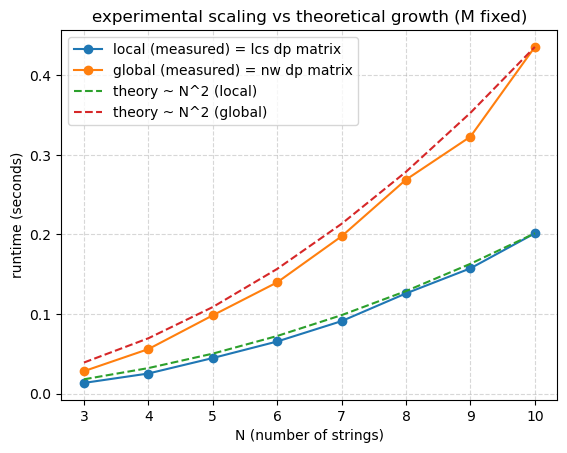

In [143]:
import time
import matplotlib.pyplot as plt

def avg_runtime_seconds(run_fn, repeats=3):
    """
    Time a function a few times and return the average runtime.

    Parameters
    ----------
    run_fn : callable
        a function that takes no arguments and runs the computation we want to time
    repeats : int
        how many times to repeat the timing (we average to reduce noise)

    Returns
    -------
    float
        average runtime in seconds
    """
    times = []
    for _ in range(repeats):
        t0 = time.perf_counter()
        run_fn()
        t1 = time.perf_counter()
        times.append(t1 - t0)
    return sum(times) / len(times)


# choose M fixed and vary N
M = 200
N_values = [3, 4, 5, 6, 7, 8, 9, 10]

greedy_times = []
global_times = []

for N in N_values:
    test_set = make_random_set_strings(N, M, seed=N)
    _, seqs = unpack_set_strings(test_set)

    def run_greedy():
        """
        local strategy timing.

        for q5 i only time the dominant cost of the local method:
        building the pairwise lcs distance matrix (dp over all pairs).
        the actual greedy tree building step is lower-order and also
        assumes a fixed 7-node structure in our q3 implementation,
        so timing just the dp part is the clean scaling experiment.
        """
        _ = lcs_dist_matrix_from_lcs_length(seqs)

    def run_global():
        """
        global strategy timing.

        for q5 i only time the dominant cost of the global method:
        building the pairwise needleman–wunsch distance matrix (dp over all pairs).
        the tree search/inference step is a separate layer on top of the matrix and
        in our project code it was designed specifically for 7 nodes, so this keeps
        the scaling experiment valid when n changes.
        """
        _ = nw_dist_matrix_from_score(seqs)

    greedy_times.append(avg_runtime_seconds(run_greedy, repeats=3))
    global_times.append(avg_runtime_seconds(run_global, repeats=3))


# ---- theoretical curves (scaled to match the plot shape) ----
# since M is fixed, the dp part scales like:
#   pairwise comparisons = O(N^2)
# and each comparison costs O(M^2), which is constant here
Ns = np.array(N_values, dtype=float)

theory_greedy = Ns**2
theory_global = Ns**2  # same dominant dp scaling when M is fixed

# scale curves so they sit near the measured curves (for shape comparison only)
theory_greedy = theory_greedy / theory_greedy.max() * max(greedy_times)
theory_global = theory_global / theory_global.max() * max(global_times)


# ---- plot ----
plt.figure()
plt.plot(N_values, greedy_times, marker="o")
plt.plot(N_values, global_times, marker="o")
plt.plot(N_values, theory_greedy, linestyle="--")
plt.plot(N_values, theory_global, linestyle="--")

plt.xlabel("N (number of strings)")
plt.ylabel("runtime (seconds)")
plt.title("experimental scaling vs theoretical growth (M fixed)")
plt.legend([
    "local (measured) = lcs dp matrix",
    "global (measured) = nw dp matrix",
    "theory ~ N^2 (local)",
    "theory ~ N^2 (global)"
])
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

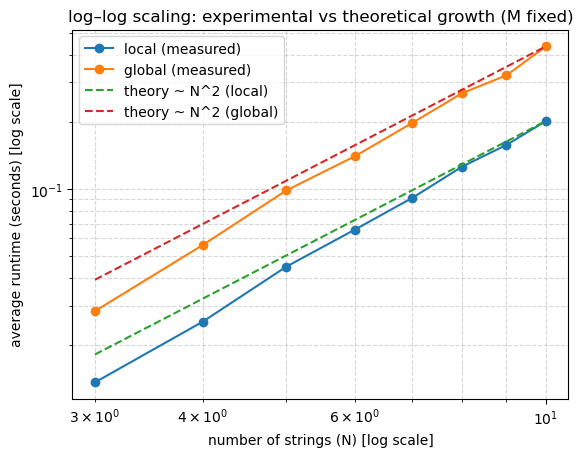

In [144]:
# ---- log–log plot (both axes on a log scale) ----

plt.figure()

# experimental measurements
plt.loglog(N_values, greedy_times, marker="o")
plt.loglog(N_values, global_times, marker="o")

# theoretical curves
plt.loglog(N_values, theory_greedy, linestyle="--")
plt.loglog(N_values, theory_global, linestyle="--")

plt.xlabel("number of strings (N) [log scale]")
plt.ylabel("average runtime (seconds) [log scale]")
plt.title("log–log scaling: experimental vs theoretical growth (M fixed)")

plt.legend([
    "local (measured)",
    "global (measured)",
    "theory ~ N^2 (local)",
    "theory ~ N^2 (global)"
])

plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

Q6 Mutation probability estimation

In [ ]:
def nw_align(parent, child, match=1, mismatch=-1, gap=-1):
    """
    Global alignment (needleman–wunsch) with traceback.

    I need the alignment, not just the score, because i want to count: insertions, deletions, and substitutions along a parent -> child edge.

    parameters
    ----------
    parent : str
        the "parent" gene sequence
    child : str
        the "child" gene sequence
    match, mismatch, gap : int
        scoring settings for the dp recurrence

    returns
    -------
    (str, str)
        aligned_parent, aligned_child using '-' for gaps
    """
    m = len(parent)
    n = len(child)

    # dp table of best scores for prefixes
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    # traceback table: "D" diagonal, "U" up, "L" left
    move = [[None] * (n + 1) for _ in range(m + 1)]

    # initialize borders (only gaps possible)
    for i in range(1, m + 1):
        dp[i][0] = dp[i - 1][0] + gap
        move[i][0] = "U"
    for j in range(1, n + 1):
        dp[0][j] = dp[0][j - 1] + gap
        move[0][j] = "L"

    # fill dp table (same idea as clrs lcs-length, just different recurrence)
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            diag = dp[i - 1][j - 1] + (match if parent[i - 1] == child[j - 1] else mismatch)
            up = dp[i - 1][j] + gap
            left = dp[i][j - 1] + gap

            best = max(diag, up, left)
            dp[i][j] = best

            # deterministic tie-break so results are reproducible
            if best == diag:
                move[i][j] = "D"
            elif best == up:
                move[i][j] = "U"
            else:
                move[i][j] = "L"

    # traceback
    aligned_p = []
    aligned_c = []
    i, j = m, n

    while i > 0 or j > 0:
        step = move[i][j]
        if step == "D":
            aligned_p.append(parent[i - 1])
            aligned_c.append(child[j - 1])
            i -= 1
            j -= 1
        elif step == "U":
            aligned_p.append(parent[i - 1])
            aligned_c.append("-")
            i -= 1
        else:  # "L"
            aligned_p.append("-")
            aligned_c.append(child[j - 1])
            j -= 1

    aligned_p.reverse()
    aligned_c.reverse()
    return "".join(aligned_p), "".join(aligned_c)

In [146]:
def count_events(aligned_parent, aligned_child):
    """
    Count insertions/deletions/substitutions/matches from an alignment.

    Definitions i use for q6:
    - insertion: parent has '-' and child has a base
    - deletion: parent has a base and child has '-'
    - substitution: both have bases but they differ
    - match: both have bases and they are the same

    parameters
    ----------
    aligned_parent : str
    aligned_child : str

    returns
    -------
    dict
        counts for 'ins', 'del', 'sub', 'match'
    """
    counts = {"ins": 0, "del": 0, "sub": 0, "match": 0}

    for a, b in zip(aligned_parent, aligned_child):
        if a == "-" and b != "-":
            counts["ins"] += 1
        elif a != "-" and b == "-":
            counts["del"] += 1
        elif a != "-" and b != "-":
            if a == b:
                counts["match"] += 1
            else:
                counts["sub"] += 1

    return counts

In [147]:
def estimate_probs_from_tree(tree_tuple, sequences, match=1, mismatch=-1, gap=-1, alpha=1):
    """
    Estimating probabilities of insertion/deletion/mutation using the genealogy.

    I treat each edge as one evolutionary step (parent -> child).
    For each edge I:
      1) compute a global alignment using needleman–wunsch (dp + traceback)
      2) count events from the alignment
    then I sum counts over all edges and convert to probabilities.

    parameters
    ----------
    tree_tuple : tuple
        (g, p1, p2, c11, c12, c21, c22) as indices into sequences
    sequences : list[str]
        sequences in the same index order as the tree
    match, mismatch, gap : int
        nw scoring settings
    alpha : float
        laplace smoothing (helps because dataset is tiny)

    returns
    -------
    (dict, dict)
        (total_counts, probabilities)
    """
    g, p1, p2, c11, c12, c21, c22 = tree_tuple
    edges = [(g, p1), (g, p2), (p1, c11), (p1, c12), (p2, c21), (p2, c22)]

    total = {"ins": 0, "del": 0, "sub": 0, "match": 0}

    for parent_i, child_i in edges:
        parent_seq = sequences[parent_i]
        child_seq = sequences[child_i]

        aligned_p, aligned_c = nw_align(parent_seq, child_seq, match=match, mismatch=mismatch, gap=gap)
        counts = count_events(aligned_p, aligned_c)

        # add into totals
        for k in total:
            total[k] += counts[k]

    # convert counts to probabilities with laplace smoothing
    denom = (total["ins"] + total["del"] + total["sub"] + total["match"]) + 4 * alpha

    probs = {
        "p_ins": (total["ins"] + alpha) / denom,
        "p_del": (total["del"] + alpha) / denom,
        "p_sub": (total["sub"] + alpha) / denom,
        "p_match": (total["match"] + alpha) / denom,
    }

    return total, probs

In [148]:
# we already have these from q4
# labels, sequences = unpack_set_strings(set_strings)

local_counts, local_probs = estimate_probs_from_tree(local_tree_tuple, sequences)
global_counts, global_probs = estimate_probs_from_tree(best_tree_tuple, sequences)

print("local totals:", local_counts)
print("local probs:", local_probs)

print("\nglobal totals:", global_counts)
print("global probs:", global_probs)

local totals: {'ins': 185, 'del': 18, 'sub': 161, 'match': 1591}
local probs: {'p_ins': 0.09494640122511486, 'p_del': 0.009698825931597753, 'p_sub': 0.08269525267993874, 'p_match': 0.8126595201633486}

global totals: {'ins': 185, 'del': 18, 'sub': 161, 'match': 1591}
global probs: {'p_ins': 0.09494640122511486, 'p_del': 0.009698825931597753, 'p_sub': 0.08269525267993874, 'p_match': 0.8126595201633486}
